In [110]:
import tensorflow as tf
import transformers
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt

# if you want, not required
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split
import utils as utils

import numpy as np
import keras
from keras import layers

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import LSTM, Dense

from gensim.models import Word2Vec

from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

In [111]:
# Version Info
print("Tensforflow Version : " ,tf.__version__)
print("Transformers Version : " ,transformers.__version__)

Tensforflow Version :  2.14.0
Transformers Version :  4.35.0


In [112]:
# make a data folder
!mkdir -p data

# download the data
out_path = tf.keras.utils.get_file(origin="https://archive.ics.uci.edu/static/public/331/sentiment+labelled+sentences.zip",extract=True,cache_dir="data")
print("\n",out_path)


 data\datasets\sentiment+labelled+sentences.zip


A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file data already exists.
Error occurred while processing: data.


In [113]:
# Read the CSV file into a DataFrame
df = pd.read_csv('text_entailment_dataset/train.csv')

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42)  # Shuffle with fixed seed for reproducibility

# Split the data into training and validation sets
train_df, validation_df = train_test_split(df, test_size=0.1, random_state=42)

# Write the training and validation DataFrames to separate CSV files
train_df.to_csv('text_entailment_dataset/train_data.csv', index=False)
validation_df.to_csv('text_entailment_dataset/validation_data.csv', index=False)

train_dataset = df = pd.read_csv('text_entailment_dataset/train_data.csv')
validation_dataset = df = pd.read_csv('text_entailment_dataset/validation_data.csv')
#test_dataset = df = pd.read_csv('text_entailment_dataset/test_data.csv')

train_dataset.head()


,premise,hypothesis,label
0,a dog chases a red ball.,A cute dog paly with a ball.,0
1,A carefully dressed you boy is nonverbally com...,A young boy dressed in a potato sack is trying...,2
2,A black and white dog jumps in the snow.,The dogs are leaping into the snow.,0
3,A man singing and playing guitar on a busy sid...,A man is performing on a city sidewalk,0
4,A man holding a rifle next to his brown dog.,A man is climbing a tree.,2


In [114]:
train_dataset.shape

(494424, 3)

In [115]:
validation_dataset.head()

,premise,hypothesis,label
0,A young couple looking at different types and ...,a couple is looking,0
1,A man in a purple had climbs a rocky wall with...,A man is going to the temple.,2
2,A group of friends playing cards and trying to...,The people are playing a card game.,0
3,People looking at fish at an aquarium.,People looking at fish.,0
4,An older lady blowing out a 9 and a 0 number c...,A woman drinks coffee while driving.,2


In [116]:
validation_dataset.shape


(54937, 3)

In [117]:
#test_dataset.head()


In [118]:
#test_dataset.shape

In [119]:
# import specific models
from transformers import DistilBertModel, DistilBertConfig

# define a max length constant
MAX_LENGTH = 128
TRUNC = 10000

In [120]:
from transformers import DistilBertTokenizer, DistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [121]:
print(tokenizer)
print(bert)

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position

In [122]:
train_dataset[["premise"]] = train_dataset[["premise"]].astype(str)
train_dataset["premise"] = train_dataset["premise"].apply(utils.change_lower)
train_dataset["premise"] = train_dataset["premise"].apply(utils.clean_data)
train_dataset["premise"] = train_dataset["premise"].apply(utils.remover)

test_dataset[["hypothesis"]] = train_dataset[["hypothesis"]].astype(str)
train_dataset["hypothesis"] = train_dataset["hypothesis"].apply(utils.change_lower)
train_dataset["hypothesis"] = train_dataset["hypothesis"].apply(utils.clean_data)
train_dataset["hypothesis"] = train_dataset["hypothesis"].apply(utils.remover)

validation_dataset[["premise"]] = validation_dataset[["premise"]].astype(str)
validation_dataset["premise"] = validation_dataset["premise"].apply(utils.change_lower)
validation_dataset["premise"] = validation_dataset["premise"].apply(utils.clean_data)
validation_dataset["premise"] = validation_dataset["premise"].apply(utils.remover)

validation_dataset[["hypothesis"]] = validation_dataset[["hypothesis"]].astype(str)
validation_dataset["hypothesis"] = validation_dataset["hypothesis"].apply(utils.change_lower)
validation_dataset["hypothesis"] = validation_dataset["hypothesis"].apply(utils.clean_data)
validation_dataset["hypothesis"] = validation_dataset["hypothesis"].apply(utils.remover)

test_dataset[["premise"]] = test_dataset[["premise"]].astype(str)
test_dataset["premise"] = test_dataset["premise"].apply(utils.change_lower)
test_dataset["premise"] = test_dataset["premise"].apply(utils.clean_data)
test_dataset["premise"] = test_dataset["premise"].apply(utils.remover)

test_dataset[["hypothesis"]] = test_dataset[["hypothesis"]].astype(str)
test_dataset["hypothesis"] = test_dataset["hypothesis"].apply(utils.change_lower)
test_dataset["hypothesis"] = test_dataset["hypothesis"].apply(utils.clean_data)
test_dataset["hypothesis"] = test_dataset["hypothesis"].apply(utils.remover)

In [123]:
X_train = train_dataset['premise'] + train_dataset['hypothesis']
X_Val = validation_dataset['premise'] + validation_dataset['hypothesis']
X_test = test_dataset['premise'] + test_dataset['hypothesis']

In [124]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [125]:
# define a batch size for our experiments
BATCH_SIZE = 64
# define a percentage of the data to use for training
SPLIT_PC = .80

# TODO: caluculate the last index for the training data
# 
# imdb_lengths = [len(review) for review in imdb_df.loc[:,0]]
# amazon_lengths = [len(review) for review in amazon_df.loc[:,0]]
# yelp_lengths = [len(review) for review in yelp_df.loc[:,0]]
# 
# #x = []
# #x.append(data[0].str.len())
# x = [length for length in lengths]

train_dataset = df = pd.read_csv('text_entailment_dataset/train_data.csv')
validation_dataset = df = pd.read_csv('text_entailment_dataset/validation_data.csv')
#test_dataset = df = pd.read_csv('text_entailment_dataset/test_data.csv')


# # Total number of samples
# total_samples = len(train_dataset)
# print(total_samples)
# 
# # Calculate the number of samples to be used for training
# train_samples = int(total_samples * SPLIT_PC)
# 
# # Calculate the last index for the training data
# END = train_samples
# print(END)


In [126]:
print(test_dataset)

                                                premise  \
0     church choir sings masses sing joyous songs bo...   
1     church choir sings masses sing joyous songs bo...   
2     church choir sings masses sing joyous songs bo...   
3             woman green headscarf blue shirt big grin   
4             woman green headscarf blue shirt big grin   
...                                                 ...   
9819             two women observing something together   
9820             two women observing something together   
9821  man black leather jacket book hand speaks clas...   
9822  man black leather jacket book hand speaks clas...   
9823  man black leather jacket book hand speaks clas...   

                                         hypothesis  
0                                cute dog paly ball  
1     young boy dressed potato sack trying eat soup  
2                                 dogs leaping snow  
3                      man performing city sidewalk  
4                    

In [127]:
#  TODO: get the training data and testing data set up
train_sentences = [train_dataset.loc[s][0] + train_dataset.loc[s][1] for s in range(len(train_dataset))]
train_labels = [train_dataset.loc[l][2] for l in range(len(train_dataset))]

validation_sentences = [validation_dataset.loc[s][0] + validation_dataset.loc[s][1] for s in range(len(validation_dataset))]
validation_labels = [validation_dataset.loc[l][2] for l in range(len(validation_dataset))]

# TODO: add print statements to verify the sizes of your training/testing data are correct
print("LENGTHS // Train sentences: " + str(len(train_sentences)) + ". Train labels: " + str(len(train_labels)))
print("LENGTHS // Test sentences: " + str(len(validation_sentences)) + ". Test labels: " + str(len(validation_labels)))

C:\Users\chris\AppData\Local\Temp\ipykernel_29664\3991041832.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_sentences = [train_dataset.loc[s][0] + train_dataset.loc[s][1] for s in range(len(train_dataset))]
C:\Users\chris\AppData\Local\Temp\ipykernel_29664\3991041832.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_labels = [train_dataset.loc[l][2] for l in range(len(train_dataset))]
C:\Users\chris\AppData\Local\Temp\ipykernel_29664\3991041832.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

LENGTHS // Train sentences: 494424. Train labels: 494424
LENGTHS // Test sentences: 54937. Test labels: 54937


In [128]:
train_labels = train_dataset["label"]
validation_labels = validation_dataset["label"]

# Convert to one-hot encoded format
num_classes = len(set(train_labels))  # Calculate the number of classes

train_labels = to_categorical(train_labels, num_classes=num_classes)
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

print("train label shape:", train_labels.shape)
print("val label shape:", validation_labels.shape)

steps_per_epoch = len(train_labels) // BATCH_SIZE
validation_steps = len(validation_labels) // BATCH_SIZE


train label shape: (494424, 3)
val label shape: (54937, 3)


In [129]:
# data generator for the model
def data_generator(sentences: np.array,labels: np.array,batch_size: int) -> (dict,tf.Tensor):
    i = 0
    start_idx = -1 * batch_size
    end_idx = 0

    while True:
        start_idx += batch_size
        end_idx += batch_size
        # TODO: append batch_size number of sentences and labels to batch_x and batch_y
        # Make sure that you don't re-use sentences and labels that you've already put into batches!

        if end_idx > len(sentences):
            end_idx = batch_size
            start_idx = 0

        batch_y = labels[start_idx:end_idx]

        # TODO: tokenize the batch_x, padding to MAX_LENGTH, and truncating to MAX_LENGTH
        batch_x = tokenizer(sentences[start_idx:end_idx], return_tensors="tf", max_length=MAX_LENGTH, truncation="longest_first", padding="max_length")

        # debugging prints (make sure that these are commented out when you actually train your model)
        # should be (batch_size, MAX_LENGTH)
        # print(batch_x['input_ids'].shape)

        # convert our ys into the appropriate tensor
        batch_y = tf.convert_to_tensor(batch_y)

        # debugging prints (make sure that these are commented out when you actually train your model)
        # should be (batch_size,)
        # print(batch_y.shape)
        yield dict(batch_x), batch_y

# np.random.seed(42)
# shuffled_indices = np.random.permutation(len(train_sentences))
# 
# shuffled_sentences_t = [train_sentences[i] for i in shuffled_indices[:TRUNC]]
# shuffled_labels_t = [train_labels[i] for i in shuffled_indices[:TRUNC]]
# 
# shuffled_sentences_v = [train_sentences[i] for i in shuffled_indices[:TRUNC]]
# shuffled_labels_v = [train_labels[i] for i in shuffled_indices[:TRUNC]]

# train_data = data_generator(shuffled_sentences_t,shuffled_labels_t,BATCH_SIZE)
# test_data = data_generator(validation_sentences,validation_labels,BATCH_SIZE)

train_data = data_generator(train_sentences,train_labels,BATCH_SIZE)
test_data = data_generator(validation_sentences,validation_labels,BATCH_SIZE)

In [130]:
# TODO: Take a look at the contents of tmp_batch_x and tmp_batch_y and report the shapes of the `input_ids`
# and the y label tensor.
# make sure that the shapes are what you expect them to be
# (take a look at the comments in the data_generator code)

tmp_batch_x,tmp_batch_y = next(train_data)
test_batch_x, test_batch_y = next(test_data)

print(tmp_batch_x["input_ids"].shape)
print(tmp_batch_y.shape)
#print(tmp_batch_y)

print(test_batch_x["input_ids"].shape)
print(test_batch_y.shape)
print(test_batch_y)


(64, 128)
(64, 3)
(64, 128)
(64, 3)
tf.Tensor(
[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]], shape=(64, 3), dtype=float32)


In [131]:
class MetricsCallback(Callback):
    def __init__(self, tokenizer, X_val, y_val):
        super(MetricsCallback, self).__init__()
        self.tokenizer = tokenizer
        self.X_val = X_val
        self.y_val = y_val
        self.metrics = {'epoch': [], 'precision': [], 'recall': [], 'f1': [], 'val_loss': [], 'val_accuracy': [], 'loss': [], 'accuracy': []}

    def on_epoch_end(self, epoch, logs=None):
        # Tokenize validation sentences
        encoded_X_val = self.tokenizer(self.X_val, return_tensors="tf", max_length=MAX_LENGTH, truncation="longest_first", padding="max_length")

        # Evaluate the model
        val_loss, val_accuracy = self.model.evaluate(encoded_X_val, self.y_val, verbose=0)
        val_pred = self.model.predict(encoded_X_val)
        val_pred_classes = np.argmax(val_pred, axis=1)  # Convert probabilities to classes

        precision = precision_score(np.argmax(self.y_val, axis=1), val_pred_classes, average='weighted')
        recall = recall_score(np.argmax(self.y_val, axis=1), val_pred_classes, average='weighted')
        f1 = f1_score(np.argmax(self.y_val, axis=1), val_pred_classes, average='weighted')

        self.metrics['epoch'].append(epoch + 1)
        self.metrics['precision'].append(precision)
        self.metrics['recall'].append(recall)
        self.metrics['f1'].append(f1)
        self.metrics['val_loss'].append(val_loss)
        self.metrics['val_accuracy'].append(val_accuracy)
        self.metrics['loss'].append(logs['loss'])
        self.metrics['accuracy'].append(logs['accuracy'])

        print("Epoch {}: Validation Precision = {:.4f}, Recall = {:.4f}, F1 Score = {:.4f}, Val Loss = {:.4f}, Val Accuracy = {:.4f}".format(epoch + 1, precision, recall, f1, val_loss, val_accuracy))



In [134]:
from keras.src.callbacks import History
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope
from transformers import TFDistilBertModel
import tensorflow_model_optimization as tfmot
# Build the model
# This takes < 15 sec to run on our computer

bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased',output_attentions = False,return_dict=False)
# we do not need attention outputs
# we want to return tuples since they are easier to access

bert_model.trainable = False
# setting trainable to false ensures
# we do not update its weights
# 

model_ = tf.keras.Sequential([
    bert_model,
    tf.keras.layers.Lambda(lambda x: x[0][:,0,:]), # https://keras.io/api/layers/core_layers/lambda/
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Dense(3,activation="softmax") # we have 3 classes
])

# Define custom metrics functions
def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1 = 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))
    return f1


# Define a checkpoint callback to save the best model
checkpoint = ModelCheckpoint('distilbert_trained_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Load the saved model
#model = load_model('trained.h5')  # Or path to SavedModel directory
# Define custom objects dictionary with TFBertModel
custom_objects = {'TFBertModel': TFBertModel}


# Compile the model with custom metrics
model_.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall, f1])

#metrics_callback = MetricsCallback(tokenizer, validation_sentences, validation_labels)
# Define a callback to collect metrics history
history = History()



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [135]:
print(len(train_sentences)//BATCH_SIZE)

7725


In [138]:
model_.fit(
    train_data,
    epochs=7,
    batch_size=BATCH_SIZE,
    steps_per_epoch=BATCH_SIZE,
    validation_data=test_data,
    validation_steps=BATCH_SIZE,
    validation_batch_size=BATCH_SIZE,
    callbacks=[history, checkpoint]
)

Epoch 1/7
64/64 [==============================] - ETA: 0s - loss: 1.0588 - accuracy: 0.4360 - precision: 0.5498 - recall: 0.1306 - f1: 0.2030
Epoch 1: val_loss improved from inf to 1.01917, saving model to distilbert_trained_model.h5


C:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - 357s 6s/step - loss: 1.0588 - accuracy: 0.4360 - precision: 0.5498 - recall: 0.1306 - f1: 0.2030 - val_loss: 1.0192 - val_accuracy: 0.4871 - val_precision: 0.5920 - val_recall: 0.1846 - val_f1: 0.2797
Epoch 2/7
64/64 [==============================] - ETA: 0s - loss: 1.0296 - accuracy: 0.4766 - precision: 0.5693 - recall: 0.1868 - f1: 0.2795
Epoch 2: val_loss improved from 1.01917 to 1.01562, saving model to distilbert_trained_model.h5
64/64 [==============================] - 296s 5s/step - loss: 1.0296 - accuracy: 0.4766 - precision: 0.5693 - recall: 0.1868 - f1: 0.2795 - val_loss: 1.0156 - val_accuracy: 0.4895 - val_precision: 0.5967 - val_recall: 0.2212 - val_f1: 0.3209
Epoch 3/7
64/64 [==============================] - ETA: 0s - loss: 1.0233 - accuracy: 0.4863 - precision: 0.5868 - recall: 0.1948 - f1: 0.2907
Epoch 3: val_loss improved from 1.01562 to 0.99613, saving model to distilbert_trained_model.h5
64/64 [==============================]

In [139]:
# Access the metrics history
print(history.history.keys())  # To see what metrics are available

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1'])


In [140]:
import numpy as np

# Access the metrics history
epochs = list(range(1, len(history.history['accuracy']) + 1))  # Assuming all metrics have the same length
precision = np.array(history.history['precision'])
recall = np.array(history.history['recall'])
f1 = np.array(history.history['f1'])
accuracy = np.array(history.history['accuracy'])
loss = np.array(history.history['loss'])
val_accuracy = np.array(history.history['val_accuracy'])
val_loss = np.array(history.history['val_loss'])


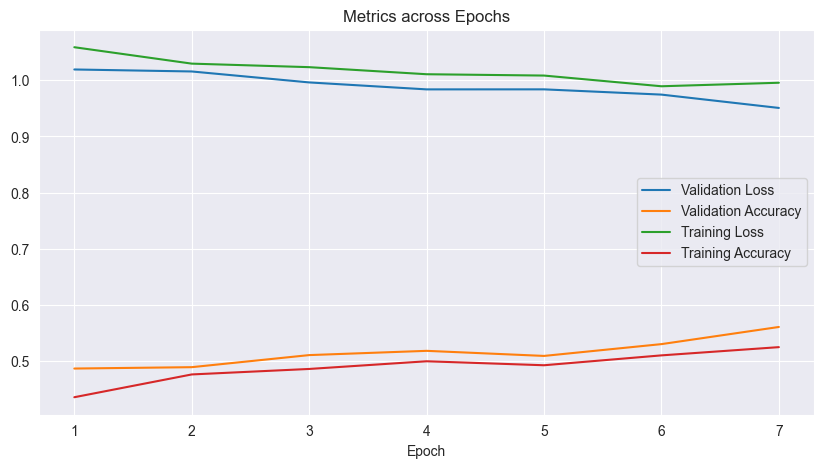

In [141]:
# Plot all four metrics on one graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_loss, label='Validation Loss')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, accuracy, label='Training Accuracy')

plt.title('Metrics across Epochs')
plt.xlabel('Epoch')
plt.xticks(epochs)
plt.legend()
plt.savefig("Transformer_BERT_training_val_loss_acc(1).pdf")  # Save the plot before showing
plt.show()


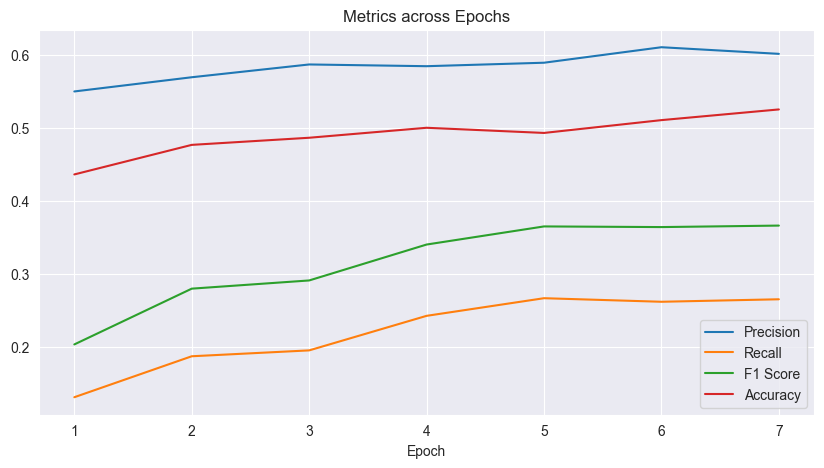

In [142]:
# Plot all four metrics on one graph
plt.figure(figsize=(10, 5))
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, recall, label='Recall')
plt.plot(epochs, f1, label='F1 Score')
plt.plot(epochs, accuracy, label='Accuracy')

plt.title('Metrics across Epochs')
plt.xlabel('Epoch')
plt.xticks(epochs)
plt.legend()
plt.savefig("Transformer_BERT_training_PRFA(1).pdf")
plt.show()